# Summary

This notebook builds upon the tutorial:

https://blog.fastforwardlabs.com/2018/04/10/pytorch-for-recommenders-101.html

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import utils
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
device

device(type='cuda')

In [2]:
rating, user_column_index, item_column_index = utils.get_movielens_data()

(100000, 4)
(1682, 24)
(943, 5)


In [3]:
# Data preprocessing
rating["rating"] = rating["rating"]/5
# rating["rating"] =  MinMaxScaler().fit_transform(rating[["rating"]].values).reshape(-1)

In [7]:
n_users = rating["userid"].max() + 1
n_items = rating["itemid"].max() + 1
print(n_users, n_items)
train_df, test_df = utils.movielens_train_test_split(rating)
train_df.shape, test_df.shape

train_df, val_df = utils.movielens_train_test_split(train_df)
train_df.shape, val_df.shape

944 1683


((98105, 49), (943, 49))

<AxesSubplot:>

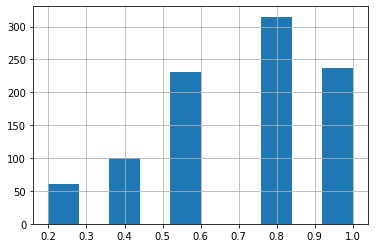

In [8]:
test_df["rating"].hist()

In [9]:
print(np.mean(np.abs(test_df["rating"].values - test_df["rating"].mean())))
print(np.mean(np.abs(test_df["rating"].values - train_df["rating"].mean())))
print(np.mean(np.abs(test_df["rating"].values - train_df["rating"].mode()[0])))
print(np.mean(np.abs(test_df["rating"].values - test_df["rating"].mode()[0])))

0.19339420117424932
0.19594300758655422
0.17985153764581127
0.17985153764581127


# Model definition

In [10]:
class DenseNet(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors, H1, D_out):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        sparse = False
        self.user_factors = torch.nn.Embedding(n_users,
                                               n_factors,
                                               sparse=sparse)
        self.item_factors = torch.nn.Embedding(n_items,
                                               n_factors,
                                               sparse=sparse)
        # linear layers
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(n_factors * 2, 4 * H1), torch.nn.ReLU(),
            torch.nn.Linear(4 * H1, H1), torch.nn.ReLU(),
            torch.nn.Linear(H1, D_out))

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        output_scores = self.linear(x)
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores

In [11]:
model = DenseNet(n_users, n_items, n_factors=20, H1 = 20, D_out= 1)
loss_fn = torch.nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
trainloader = DataLoader(train_df.values, batch_size=128, shuffle=True)
valloader = DataLoader(val_df.values, batch_size=128)
testloader = DataLoader(test_df.values, batch_size=128)
model = model.to(device)
model

DenseNet(
  (user_factors): Embedding(944, 20)
  (item_factors): Embedding(1683, 20)
  (linear): Sequential(
    (0): Linear(in_features=40, out_features=80, bias=True)
    (1): ReLU()
    (2): Linear(in_features=80, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [12]:
def evaluate(loader):
    maes = []
    for batch in loader:
        user = batch[:, 0].type(torch.LongTensor).to(device)
        item = batch[:, 1].type(torch.LongTensor).to(device)

        score = batch[:, 2].type(torch.FloatTensor)
        prediction = model(user, item)
        mae = mean_absolute_error(score.cpu().detach().numpy(),  prediction.cpu().detach().numpy())
        maes.append(mae)
    return np.mean(maes)

## Model training

In [1]:
losses = []
val_scores = []
test_scores = []
for epoch in range(100):
    losses_epoch = []
    for batch in tqdm(trainloader):
        optimizer.zero_grad()
        user = batch[:, 0].type(torch.LongTensor).to(device)
        item = batch[:, 1].type(torch.LongTensor).to(device)

        score = batch[:, 2].view(-1, 1).type(torch.FloatTensor)
        prediction = model(user, item)
        loss = loss_fn(prediction, score.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        losses_epoch.append(loss.item())
    losses.append(np.mean(losses_epoch))
    val_scores.append(evaluate(valloader))
    test_scores.append(evaluate(testloader))
    print(losses[-1])
    print(f"{epoch}) VAL {val_scores[-1]}, TEST {test_scores[-1]}")

# Visualize results

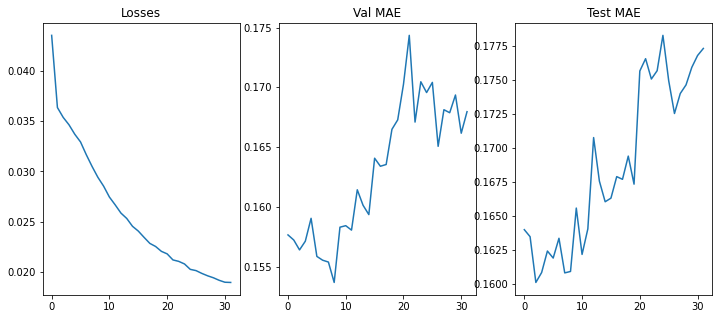

In [16]:
plt.figure(figsize = (12, 5))
plt.subplot(131)
plt.title("Losses")
plt.plot(losses)
plt.subplot(132)
plt.title("Val MAE")
plt.plot(val_scores)

plt.subplot(133)
plt.title("Test MAE")
plt.plot(test_scores)
plt.tight_layout()